In [1]:
from bs4 import BeautifulSoup as bs
import requests
from datetime import datetime
import pandas as pd
import numpy as np
import re
import time
import math
import worker1 as w1
import worker2 as w2
import random

2021-11-26 20:11:09,249 loading file C:\Users\soham\.flair\models\sentiment-en-mix-distillbert_4.pt


#### Scraping single web page sequentially

In [2]:
ids = ["signals_1","signals_2"]
tickers = {'ticker':[],'href':[],'state':[]}
for i in ids:
    url = "https://finviz.com/"
    html_text = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'}).text
    soup = bs(html_text,"html.parser")
    table = soup.find("table",{"id":i})
    rows = table.find_all('tr')
    for row in rows:
        try:
            anchor_ticker = row.find('a',{'class':'tab-link'})
            anchor_state = row.find('a',{'class':'tab-link-nw'})
            href = anchor_ticker['href']
            ticker = anchor_ticker.decode_contents()
            state = anchor_state.decode_contents()
            tickers['ticker'].append(ticker)
            tickers['href'].append(href)
            tickers['state'].append(state)
        except:
            pass

In [3]:
df = pd.DataFrame(tickers).iloc[:,[0,2]]
href_ticker = tickers['ticker']
print(href_ticker)

['LGVN', 'BFRI', 'PTN', 'IMCC', 'BSFC', 'LOV', 'FEMY', 'LGVN', 'MOV', 'PSTG', 'IRMD', 'COKE', 'TRT', 'OCUP', 'BFRI', 'PTN', 'GAME', 'BLCT', 'ESTA', 'QLGN', 'APVO', 'JWN', 'KTTA', 'VLON', 'GPS', 'CNTG', 'KURA', 'VIOT', 'PLAN', 'VSTA', 'CDZIP', 'LGVN', 'BTTX', 'BFRI', 'SQQQ', 'VG', 'NTZ', 'AOS']


#### Scraping multiple webpages sequentially

In [11]:
newdf0 = pd.DataFrame()
begin = time.time()
df1 = df[0:2]
df0 = pd.DataFrame()
num_of_tickers = len(df)
for i in range(num_of_tickers):
    #print(df1.iloc[i]['ticker'])
    newdf = w1.scrape_ticker(df.iloc[i]['ticker'])
    print(str(i+1)+" of "+str(num_of_tickers),end="\r")
    df0 = df0.append(newdf)
end = time.time()
print(f"Total time taken to scrape: {end - begin} seconds")
df0

Total time taken to scrape: 38.28608417510986 seconds


,date,ticker,company,headline
0,2021-11-24,LGVN,Longeveron Inc.,Longeveron is the short squeeze Reddit Apes ca...
1,2021-11-24,LGVN,Longeveron Inc.,Why Longeveron Stock Is Skyrocketing Today
2,2021-11-23,LGVN,Longeveron Inc.,Retail Traders Jump Back Into Tiny Biotechs Ah...
3,2021-11-22,LGVN,Longeveron Inc.,2 Moonshot Biotechs with 10x Potential
4,2021-11-22,LGVN,Longeveron Inc.,Longeveron stock vaults to another all-time high
...,...,...,...,...
95,2020-09-14,AOS,A. O. Smith Corporation,RBC vs. AOS: Which Stock Is the Better Value O...
96,2020-09-10,AOS,A. O. Smith Corporation,Hedge Funds Have Never Been This Bullish On A....
97,2020-09-01,AOS,A. O. Smith Corporation,These 4 Measures Indicate That A. O. Smith (NY...
98,2020-08-29,AOS,A. O. Smith Corporation,A.O. Smith (AOS) Up 1.9% Since Last Earnings R...


### Parallel webscraping with Pool

In [12]:
from multiprocessing import Pool
import os
cpuCount = os.cpu_count()
print("Number of CPUs in the system:", cpuCount)

Number of CPUs in the system: 4


In [13]:

newdf0 = pd.DataFrame()
results = []
time_taken = []
max_sub_procs = []
for i in range(1,cpuCount+1):
    p = Pool(i)  # Pool tells how many at a time
    begin = time.time()
    results = p.map(w1.scrape_ticker, href_ticker)
    p.terminate()
    p.join()
    end = time.time()
    print(f"Total time taken to scrape: {end - begin} seconds")
    time_taken.append(end-begin)
    max_sub_procs.append(i)


Total time taken to scrape: 47.07102680206299 seconds
Total time taken to scrape: 17.925156354904175 seconds
Total time taken to scrape: 12.281540393829346 seconds
Total time taken to scrape: 9.065622568130493 seconds


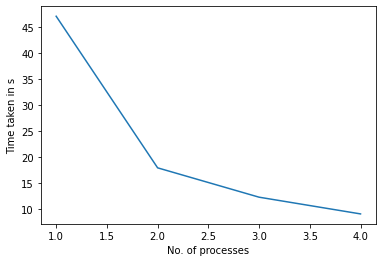

In [14]:
from matplotlib import pyplot
pyplot.plot(max_sub_procs,time_taken)
pyplot.xlabel("No. of processes")
pyplot.ylabel("Time taken in s")
pyplot.show()

### Parallel scraping with max no. of cores

As the minimum time was taken by parallel scraping on 4 cores, it is chosen for the scraping

In [16]:
results = []
p = Pool(cpuCount)  # Pool tells how many at a time
begin = time.time()
results = p.map(w1.scrape_ticker, href_ticker)
p.terminate()
p.join()
end = time.time()
print(f"Total time taken to scrape: {end - begin} seconds")
time_taken.append(end-begin)
max_sub_procs.append(i)

Total time taken to scrape: 9.892616510391235 seconds


In [17]:
data = pd.concat(results).reset_index(drop=True)
data

,date,ticker,company,headline
0,2021-11-24,LGVN,Longeveron Inc.,Longeveron is the short squeeze Reddit Apes ca...
1,2021-11-24,LGVN,Longeveron Inc.,Why Longeveron Stock Is Skyrocketing Today
2,2021-11-23,LGVN,Longeveron Inc.,Retail Traders Jump Back Into Tiny Biotechs Ah...
3,2021-11-22,LGVN,Longeveron Inc.,2 Moonshot Biotechs with 10x Potential
4,2021-11-22,LGVN,Longeveron Inc.,Longeveron stock vaults to another all-time high
...,...,...,...,...
2754,2020-09-14,AOS,A. O. Smith Corporation,RBC vs. AOS: Which Stock Is the Better Value O...
2755,2020-09-10,AOS,A. O. Smith Corporation,Hedge Funds Have Never Been This Bullish On A....
2756,2020-09-01,AOS,A. O. Smith Corporation,These 4 Measures Indicate That A. O. Smith (NY...
2757,2020-08-29,AOS,A. O. Smith Corporation,A.O. Smith (AOS) Up 1.9% Since Last Earnings R...


### TextBlob vs Flair
A comparative study was performed of seven publicly available and well-known libraries that can elicit named entities: Stanford NER, spaCy, NLTK, Polyglot, Flair, GATE and DeepPavlov.

**For the English language close values of the F1-score for the problem of Named Entities Recognition have the Flair and DeepPavlov libraries.**

S. Vychegzhanin and E. Kotelnikov, *Comparison of Named Entity Recognition Tools Applied to News Articles*, Moscow, Russia: IEEE 2019

In [18]:
from textblob import TextBlob as tb

In [19]:

news_dict_p = dict()#polarity
news_dict_s = dict()#subjectivity
begin = time.time()
counter = 0
for i in range(len(data)):
    sentence = data['headline'][i]
    try:
        analysis = tb(sentence).sentiment
        score1 = analysis.polarity#*analysis.subjectivity
        score2 = analysis.subjectivity
    except:
        score1 = 0
        score2 = 0
    news_dict_p[i]=score1
    news_dict_s[i]=score2
    counter+=1
    #print(i)
end = time.time()
print(f"Total time taken to calculate sentiment: {end - begin} seconds")
print("rows scanned: "+str(counter))

Total time taken to calculate sentiment: 1.0582904815673828 seconds
rows scanned: 2759


In [28]:

r = [random.choice(list(news_dict_p)) for i in range(10)]

xdf = pd.DataFrame({"headline":[data['headline'][i] for i in r],"sentiment_score":[news_dict_p[i] for i in r]})
xdf["subjectivity_score"] = [news_dict_s[i] for i in r]
print("Scores of 10 randomly picked headlines: \n")
xdf


Scores of 10 randomly picked headlines: 



,headline,sentiment_score,subjectivity_score
0,A Look At The Fair Value Of Viomi Technology C...,0.700000,0.900000
1,"BLCT Upcoming Deadline: Bronstein, Gewirtz &am...",0.014286,0.121429
2,Influencers with Andy Serwer: Bruce Greenwald,0.000000,0.000000
3,FDA Approves New Drug Application for Vyleesi ...,0.136364,0.454545
4,Ocuphires VEGA-1 Phase 2 Trial in Presbyopia M...,0.050000,0.400000
5,Aptevo Announces Pricing of $22 Million Offeri...,-0.300000,0.500000
6,How the coronavirus scare has driven dangerous...,-0.600000,0.900000
7,Here's Why We're Not Too Worried About Ocuphir...,0.000000,0.000000
8,Ocuphire Initiates ZETA-1 Phase 2 Clinical Tri...,0.000000,0.000000
9,Establishment Labs Announces Participation in ...,0.000000,0.000000


### Sequential with Flair

In [29]:
#from flair.embeddings import WordEmbeddings
import time
from flair.models import TextClassifier
from flair.data import Sentence
sia = TextClassifier.load('en-sentiment')

def flair_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        return "pos"
    elif "NEGATIVE" in str(score):
        return "neg"
    else:
        return "neu"


2021-11-26 20:43:44,914 loading file C:\Users\soham\.flair\models\sentiment-en-mix-distillbert_4.pt


In [36]:
sentiment = []
begin = time.time()
n = len(data)
for i in range(n):
    sentiment.append(flair_prediction(data["headline"][i]))
    print(str(i+1)+" of "+str(n),end="\r")
end = time.time()
print(f"Total time taken to calculate sentiment: {end - begin} seconds")

Total time taken to calculate sentiment: 113.76799631118774 seconds


In [32]:
print(sentiment[0:50])

['pos', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos', 'neg', 'neg', 'pos', 'pos', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'pos', 'neg', 'neg', 'pos', 'neg', 'neg', 'pos']


### Parallel with Flair and joblib

In [49]:
from joblib import Parallel, delayed
from tqdm import tqdm_notebook
from multiprocessing import cpu_count

In [35]:
import sys
import importlib
importlib.reload(w2)

2021-11-26 20:51:25,375 loading file C:\Users\soham\.flair\models\sentiment-en-mix-distillbert_4.pt


<module 'worker2' from 'C:\\Users\\soham\\PDC\\worker2.py'>

#### Multiprocessing

In [56]:

iterable = data.values

def parallelize(iterable, func,processes):
    print("Processes: "+str(processes))
    return Parallel(n_jobs=processes,prefer="processes")(delayed(func)(i) for i in tqdm_notebook(iterable))
    #return Parallel(n_jobs=1, prefer="processes")(delayed(func)(i) for i in tqdm_notebook(iterable))

returned = None
times = []
# for i in range(1,cpu_count()+1):
#     begin = time.time()
#     returned = parallelize(iterable, w2.parallel_flair_sentiment,i)
#     end = time.time()
#     print(f"Total time taken to calculate sentiment: {end - begin} seconds")
#     times.append(end - begin)



begin = time.time()
returned = parallelize(iterable, w2.parallel_flair_sentiment,cpu_count())
end = time.time()
print(f"Total time taken to calculate sentiment: {end - begin} seconds")

Processes: 4


<ipython-input-56-e819d0b82cbd>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  return Parallel(n_jobs=processes,prefer="processes")(delayed(func)(i) for i in tqdm_notebook(iterable))


  0%|          | 0/2759 [00:00<?, ?it/s]

Total time taken to calculate sentiment: 85.762136220932 seconds


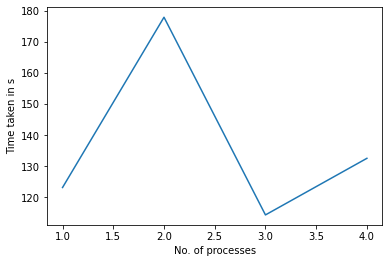

In [52]:
from matplotlib import pyplot
pyplot.plot([1,2,3,4],times)
pyplot.xlabel("No. of processes")
pyplot.ylabel("Time taken in s")
pyplot.show()

#### Multithreading

In [53]:
iterable = data.values

def parallelize(iterable, func,processes):
    print("Processes: "+str(processes))
    return Parallel(n_jobs=processes,prefer="threads")(delayed(func)(i) for i in tqdm_notebook(iterable))
    #return Parallel(n_jobs=1, prefer="processes")(delayed(func)(i) for i in tqdm_notebook(iterable))

returned = None
times2 = []
for i in range(1,cpu_count()+1):
    begin = time.time()
    returned = parallelize(iterable, w2.parallel_flair_sentiment,i)
    end = time.time()
    print(f"Total time taken to calculate sentiment: {end - begin} seconds")
    times2.append(end - begin)
#Parallel(n_jobs=cpu_count(), prefer="threads")(delayed(worker.parallel_flair_sentiment)(i) for i in tqdm_notebook(iterable))
#numpy(data.values[1])(3)

Processes: 1


<ipython-input-53-de6a77450d38>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  return Parallel(n_jobs=processes,prefer="threads")(delayed(func)(i) for i in tqdm_notebook(iterable))


  0%|          | 0/2759 [00:00<?, ?it/s]

Total time taken to calculate sentiment: 126.48633217811584 seconds
Processes: 2


  0%|          | 0/2759 [00:00<?, ?it/s]

Total time taken to calculate sentiment: 117.53100180625916 seconds
Processes: 3


  0%|          | 0/2759 [00:00<?, ?it/s]

Total time taken to calculate sentiment: 109.76595616340637 seconds
Processes: 4


  0%|          | 0/2759 [00:00<?, ?it/s]

Total time taken to calculate sentiment: 122.90000033378601 seconds


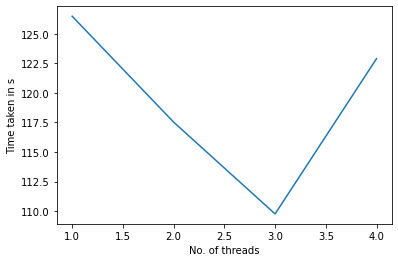

In [57]:
from matplotlib import pyplot
pyplot.plot([1,2,3,4],times2)
pyplot.xlabel("No. of threads")
pyplot.ylabel("Time taken in s")
pyplot.show()

In [59]:
iterable = data.values

def parallelize(iterable, func,processes):
    print("Threads: "+str(processes))
    return Parallel(n_jobs=processes,prefer="threads")(delayed(func)(i) for i in tqdm_notebook(iterable))
    #return Parallel(n_jobs=1, prefer="processes")(delayed(func)(i) for i in tqdm_notebook(iterable))

returned = None
begin = time.time()
returned = parallelize(iterable, w2.parallel_flair_sentiment,cpu_count())
end = time.time()
print(f"Total time taken to calculate sentiment: {end - begin} seconds")

Threads: 4


<ipython-input-59-a6d18b1e079f>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  return Parallel(n_jobs=processes,prefer="threads")(delayed(func)(i) for i in tqdm_notebook(iterable))


  0%|          | 0/2759 [00:00<?, ?it/s]

Total time taken to calculate sentiment: 99.56299901008606 seconds


In [65]:
data_final = pd.DataFrame(returned,columns = ["date","ticker","company","headline",'sentiment']).sort_values("date").reset_index(drop=True)
data_final

,date,ticker,company,headline,sentiment
0,2014-07-02,TRT,Trio-Tech International,[video] Prescription drugs: Risk vs. cost,neg
1,2014-10-08,TRT,Trio-Tech International,Trio-Tech Reports Profitable Fourth Quarter an...,pos
2,2014-10-09,TRT,Trio-Tech International,"TRIO-TECH INTERNATIONAL Files SEC form 10-K, A...",neg
3,2014-10-10,TRT,Trio-Tech International,"TRIO-TECH INTERNATIONAL Files SEC form 8-K, Re...",pos
4,2014-11-18,TRT,Trio-Tech International,Trio-Tech Reports Fiscal 2015 First Quarter Re...,pos
...,...,...,...,...,...
2754,2021-11-25,ESTA,Establishment Labs Holdings Inc.,Insiders who placed huge bets on Establishment...,neg
2755,2021-11-25,GPS,"The Gap, Inc.",10 Stocks in Focus After Posting Their Financi...,neg
2756,2021-11-26,VG,Vonage Holdings Corp.,SHAREHOLDER ALERT: Halper Sadeh LLP Investigat...,pos
2757,2021-11-26,VG,Vonage Holdings Corp.,Top 10 Stock Picks of Michael Dohenys Freshfor...,pos


Enter the ticker of which you need the daily news headline sentiment ratio
+----+----------+-----------------+----------------------------------+
|    | ticker   | state           | company                          |
|----+----------+-----------------+----------------------------------|
|  0 | LGVN     | Top Gainers     | Longeveron Inc.                  |
|  1 | LGVN     | New High        | Longeveron Inc.                  |
|  2 | LGVN     | Most Volatile   | Longeveron Inc.                  |
|  3 | BFRI     | Top Gainers     | Biofrontera Inc.                 |
|  4 | BFRI     | Unusual Volume  | Biofrontera Inc.                 |
|  5 | BFRI     | Most Active     | Biofrontera Inc.                 |
|  6 | PTN      | Top Gainers     | Palatin Technologies, Inc.       |
|  7 | PTN      | Unusual Volume  | Palatin Technologies, Inc.       |
|  8 | IMCC     | Top Gainers     | IM Cannabis Corp.                |
|  9 | BSFC     | Top Gainers     | Blue Star Foods Corp.            |
| 

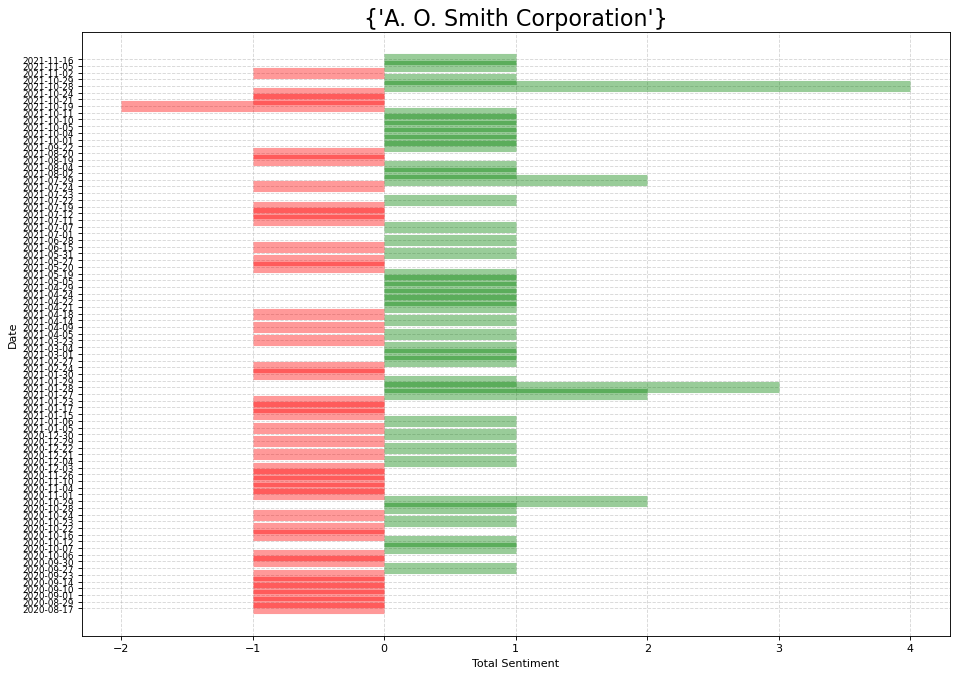

In [135]:
from tabulate import tabulate as tblt
tickerdf = pd.merge(pd.DataFrame(tickers).iloc[:,[0,2]],data_final.iloc[:,[1,2]],on='ticker').drop_duplicates().reset_index(drop=True)
print("Enter the ticker of which you need the daily news headline sentiment ratio")
print(tblt(tickerdf, headers='keys', tablefmt='psql'))
choice = input()

get_by_ticker = data_final[data_final.ticker.isin([choice])].sort_values("date").reset_index(drop=True)
print("Proportion of sentiments:")
print(get_by_ticker.sentiment.value_counts()/len(get_by_ticker)*100)
get_by_ticker.iloc[:,-1] = get_by_ticker.iloc[:,-1].replace("neg",-1)
get_by_ticker.iloc[:,-1] = get_by_ticker.iloc[:,-1].replace("pos",1)
plot_df = get_by_ticker.groupby(['date']).sum()

plot_df['date'] = plot_df.index
plot_df.reset_index(drop=True,inplace=True)
plot_df['colors'] = ['red' if float(x) < 0 else 'green' for x in plot_df['sentiment']]

pyplot.figure(figsize=(14, 10), dpi=80)
pyplot.hlines(y=plot_df['date'], xmin=0, xmax=plot_df['sentiment'],color=plot_df['colors'], alpha=0.4, linewidth=10)
pyplot.gca().set(ylabel='Date', xlabel='Total Sentiment')
pyplot.yticks(plot_df['date'], plot_df['date'], fontsize=8)
pyplot.grid(linestyle='--', alpha=0.5)
pyplot.title(str(set(data_final[data_final.ticker.isin([choice])].company.values)), fontdict={
          'size': 20})
pyplot.show()


In [ ]:
get_by_ticker = data_final[data_final.ticker.isin(["LGVN"])].sort_values("date").reset_index(drop=True)
print("Proportion of sentiments:")
print(get_by_ticker.sentiment.value_counts()/len(get_by_ticker))
get_by_ticker.iloc[:,-1] = get_by_ticker.iloc[:,-1].replace("neg",-1)
get_by_ticker.iloc[:,-1] = get_by_ticker.iloc[:,-1].replace("pos",1)
get_by_ticker

In [107]:
plot_df = get_by_ticker.groupby(['date']).sum()

plot_df['date'] = plot_df.index
plot_df.reset_index(drop=True,inplace=True)
plot_df['colors'] = ['red' if float(x) < 0 else 'green' for x in plot_df['sentiment']]
plot_df

,sentiment,date,colors
0,-3,2021-10-12,red
1,-9,2021-10-13,red
2,3,2021-10-14,green
3,0,2021-10-15,green
4,-3,2021-10-16,red
5,-3,2021-10-17,red
6,-3,2021-10-18,red
7,0,2021-10-19,green
8,0,2021-10-20,green
9,0,2021-10-21,green


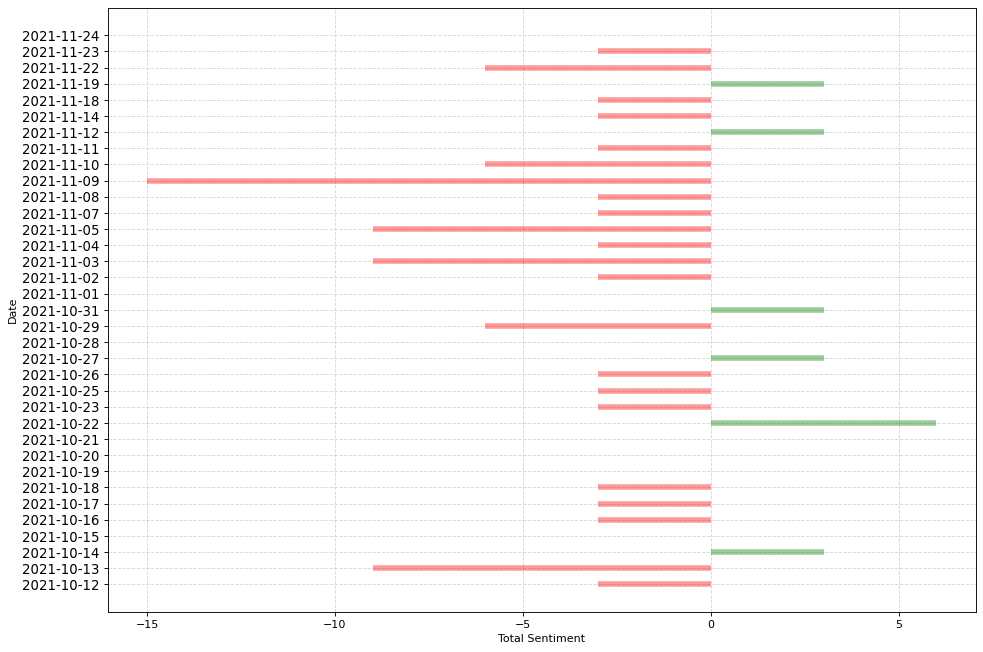

In [115]:
pyplot.figure(figsize=(14, 10), dpi=80)
pyplot.hlines(y=plot_df['date'], xmin=0, xmax=plot_df['sentiment'],
           color=plot_df['colors'], alpha=0.4, linewidth=5)
pyplot.gca().set(ylabel='Date', xlabel='Total Sentiment')
pyplot.yticks(plot_df['date'], plot_df['date'], fontsize=12)
pyplot.grid(linestyle='--', alpha=0.5)
pyplot.show()